In [1]:
import ROOT
import uproot
import math
import time
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import pandas as pd
import os
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.nn import DynamicEdgeConv, global_max_pool,global_mean_pool,knn_graph,MessagePassing
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_scatter import scatter_max, scatter_mean
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
random_state = 42
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

def plot_binned(x, y, num_bins=30, color="blue", label=None):
    """Plot mean y in bins of x."""
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)

In [2]:
# 打开 ROOT 文件，载入 events tree
Threshold=0.5*0.1328
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
ECAL_layers=30
def ReadData_Energy(DataPath,ParticleEnergy,precision=0.01):
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    Z_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,Z_layers,E_truth = ReadRoot(input_file_name)
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        Z_layers_all = np.vstack((Z_layers_all, np.vstack(Z_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
        E_truth_all = np.round(E_truth_all/precision)*precision
    return E_layers_all, N_layers_all, Z_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    Z_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, Z_layers, E_truth = ReadRoot(input_file)
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        Z_layers_all = np.vstack((Z_layers_all, Z_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, Z_layers_all, E_truth_all
def ReadRoot(input_file_name):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    num_events = len(energy)
    E_layers = []
    N_layers = []
    Z_layers = []
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        posZ = pos_z[i_event].to_numpy()
        Z_layers_event = np.bincount(layers, weights=posZ*energies, minlength=ECAL_layers)
        E_layers_event = np.bincount(layers, weights=energies, minlength=ECAL_layers)
        N_layers_event = np.bincount(layers, minlength=ECAL_layers)
        Z_layers.append(Z_layers_event/E_layers_event.clip(min=1e-6))
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,Z_layers,E_truth_flat
#Read Data
DataPath_Validate="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Train="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Uniform="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Uniform"
Energy_Train=(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,15.0,25.0,35.0,45.0,55.0,65.0)
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)#add 0.1 0.25 after all data is ready
#E_layers_train, N_layers_train, E_truth_train = ReadData_Energy(DataPath_Train,Energy_Train)
E_layers_test, N_layers_test, Z_layers_test, E_truth_test = ReadData_Energy(DataPath_Validate,Energy_test)
E_layers_uniform, N_layers_uniform, Z_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.1GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.25GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/1.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/2.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/5.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_la

length after zero suppression: 1249703 1249703 1249703 1249703 1249703 1249703
length after event selection: 1249703
length after zero suppression: 59990 59990 59990 59990 59990 59990
length after event selection: 59990
length of E_truth_test: 59990


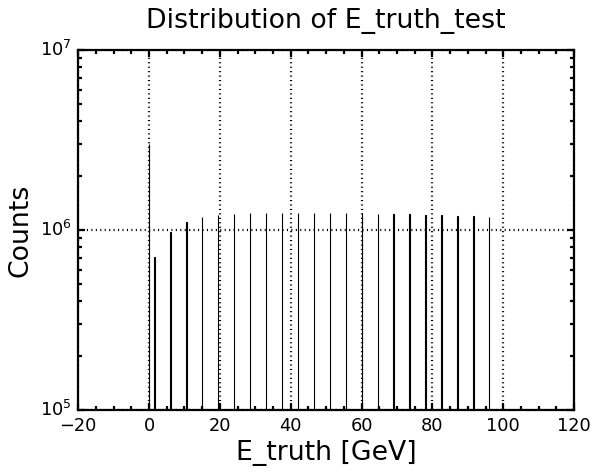

length after event selection: 59990 59990 59990 59990 59990 59990


In [3]:
#zero suppression
def zero_suppression(E_layers, N_layers, Z_layers, E_truth):
    N_sum = np.array([np.sum(n) for n in N_layers])
    E_sum = np.array([np.sum(e) for e in E_layers])
    Z_sum = np.array([np.sum(z) for z in Z_layers])
    E_truth = np.array(E_truth)

    mask = N_sum > 0
    E_layers_filtered = [E_layers[i] for i in range(len(E_layers)) if mask[i]]
    N_layers_filtered = [N_layers[i] for i in range(len(N_layers)) if mask[i]]
    Z_layers_filtered = [Z_layers[i] for i in range(len(Z_layers)) if mask[i]]
    E_truth_filtered = E_truth[mask]
    E_sum_filtered = E_sum[mask]
    N_sum_filtered = N_sum[mask]

    print("length after zero suppression:", len(E_layers_filtered), len(N_layers_filtered), len(E_sum_filtered), len(N_sum_filtered), len(Z_layers_filtered), len(E_truth_filtered))
    return E_layers_filtered, N_layers_filtered, E_sum_filtered, N_sum_filtered, Z_layers_filtered, E_truth_filtered

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

def Event_Selection(E_layers,N_layers,Z_layers,E_truth):
    E_layers, N_layers, E_sum, N_sum, Z_layers, E_truth = zero_suppression(E_layers, N_layers, Z_layers, E_truth)
    E_layers = np.array([start_from_shower_layer(ev) for ev in E_layers])
    N_layers = np.array([start_from_shower_layer(ev) for ev in N_layers])
    Z_layers = np.array([start_from_shower_layer(ev) for ev in Z_layers])
    print("length after event selection:", len(E_layers))
    return E_layers, N_layers, E_sum, N_sum, Z_layers, E_truth

#E_layers_train, N_layers_train, E_sum_train, N_sum_train, E_truth_train = Event_Selection(E_layers_train, N_layers_train, E_truth_train)
E_layers_uniform, N_layers_uniform, E_sum_uniform, N_sum_uniform, Z_layers_uniform, E_truth_uniform = Event_Selection(E_layers_uniform, N_layers_uniform, Z_layers_uniform, E_truth_uniform)
E_layers_test, N_layers_test, E_sum_test, N_sum_test, Z_layers_test, E_truth_test = Event_Selection(E_layers_test, N_layers_test, Z_layers_test, E_truth_test)
#Draw E_truth
print("length of E_truth_test:", len(E_truth_test))
plt.figure(figsize=fig_size)
plt.hist(Z_layers_uniform.flatten(), bins=1000, range=(0, 100), edgecolor="black")
#plt.hist(E_truth_test, bins=20, range=(0, 1), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.ylabel("Counts")
plt.yscale("log")
plt.title("Distribution of E_truth_test")
plt.grid(True)
plt.show()
print("length after event selection:", len(E_layers_test), len(N_layers_test), len(E_sum_test), len(N_sum_test), len(Z_layers_test), len(E_truth_test))

In [4]:
E_layers_uniform_ratio = E_layers_uniform / (E_sum_uniform[:, np.newaxis])
N_layers_uniform_ratio = N_layers_uniform / (N_sum_uniform[:, np.newaxis])
E_layers_test_ratio    = E_layers_test / (E_sum_test[:, np.newaxis])
N_layers_test_ratio    = N_layers_test / (N_sum_test[:, np.newaxis])
#performance not good
# E_layers_uniform_exp = np.exp(E_layers_uniform_ratio)
# N_layers_uniform_exp = np.exp(N_layers_uniform_ratio)
# E_layers_test_exp    = np.exp(E_layers_test_ratio)
# N_layers_test_exp    = np.exp(N_layers_test_ratio)

E_N_layers_uniform =  E_layers_uniform/(N_layers_uniform+1e-6)
E_N_layers_test    =  E_layers_test/(N_layers_test+1e-6)
#EN_layers_uniform = E_N_layers_uniform * N_layers_uniform
#EN_layers_test    = E_N_layers_test * N_layers_test

LayerNum_uniform = np.array([np.sum(e>0) for e in E_layers_uniform])
LayerNum_test    = np.array([np.sum(e>0) for e in E_layers_test])
Average_E_layer_uniform = E_sum_uniform / (LayerNum_uniform + 1e-6) 
Average_E_layer_test    = E_sum_test / (LayerNum_test + 1e-6)
Average_N_layer_uniform = N_sum_uniform / (LayerNum_uniform + 1e-6)
Average_N_layer_test    = N_sum_test / (LayerNum_test + 1e-6)

In [5]:
def ScaleFeatures(Features_train, Features_test):
    scaler = StandardScaler().fit(Features_train)
    Features_train_scaled = scaler.transform(Features_train)
    Features_test_scaled  = scaler.transform(Features_test)
    return Features_train_scaled, Features_test_scaled

E_layers_uniform_scaled, E_layers_test_scaled = ScaleFeatures(E_layers_uniform, E_layers_test)
N_layers_uniform_scaled, N_layers_test_scaled = ScaleFeatures(N_layers_uniform, N_layers_test)
Z_layers_uniform_scaled, Z_layers_test_scaled = ScaleFeatures(Z_layers_uniform, Z_layers_test)
E_N_layers_uniform_scaled, E_N_layers_test_scaled = ScaleFeatures(E_N_layers_uniform, E_N_layers_test)
E_layers_uniform_ratio_scaled, E_layers_test_ratio_scaled = ScaleFeatures(E_layers_uniform_ratio, E_layers_test_ratio)
N_layers_uniform_ratio_scaled, N_layers_test_ratio_scaled = ScaleFeatures(N_layers_uniform_ratio, N_layers_test_ratio)

extra_features_train = np.hstack([
    E_layers_uniform,
    N_layers_uniform,
    E_layers_uniform_ratio,
    E_sum_uniform[:, np.newaxis],
    N_layers_uniform_ratio,
    N_sum_uniform[:, np.newaxis],
    E_N_layers_uniform,
    #LayerNum_uniform,
    #Average_E_layer_uniform,
    #Average_N_layer_uniform
])

extra_features_test = np.hstack([
    E_layers_test,
    N_layers_test,
    E_layers_test_ratio,
    E_sum_test[:, np.newaxis],
    N_layers_test_ratio,
    N_sum_test[:, np.newaxis],
    E_N_layers_test,
    #LayerNum_test,
    #Average_E_layer_test,
    #Average_N_layer_test
])
extra_features_train, extra_features_test = ScaleFeatures(extra_features_train, extra_features_test)

In [6]:
def make_event_graph_list(conv_features, pos_features, y_true, extra_features=None, k=3):
    print("shape:", conv_features.shape, pos_features.shape, y_true.shape)
    n_events, n_nodes = conv_features.shape[:2]
    data_list = []
    conv_features = torch.tensor(conv_features, dtype=torch.float32)
    pos_features  = torch.tensor(pos_features, dtype=torch.float32)
    y_true        = torch.tensor(y_true, dtype=torch.float32)
    if extra_features is not None:
        extra_features = torch.tensor(extra_features, dtype=torch.float32)
    for i in range(n_events):
        x_conv = conv_features[i]  # (n_nodes, conv_dim)
        pos    = pos_features[i]   # (n_nodes,) or (n_nodes, pos_dim)
        x = torch.cat([x_conv, pos], dim=-1)  # (n_nodes, conv_dim+pos_dim)
        edge_index = knn_graph(pos, k=k, loop=False)
        label = y_true[i]
        extra = extra_features[i].unsqueeze(0) if extra_features is not None else None
        data = Data(
            x=x,
            edge_index=edge_index,
            y=label,
            extra=extra,
        )
        data_list.append(data)
    return data_list

def get_batch_size(device):
    if device.type == "cuda":
        total_mem = torch.cuda.get_device_properties(device).total_memory / (1024**3)  # GB
        if total_mem < 8:
            return 256
        elif total_mem < 16:
            return 1024
        else:
            return 2048
    else:
        return 128
conv_features_train = np.stack([E_layers_uniform_scaled, N_layers_uniform_scaled,E_N_layers_uniform_scaled], axis=-1)
pos_features_train = Z_layers_uniform_scaled[..., np.newaxis]
conv_features_test = np.stack([E_layers_test_scaled, N_layers_test_scaled,E_N_layers_test_scaled], axis=-1)
pos_features_test = Z_layers_test_scaled[..., np.newaxis]
conv_dim = conv_features_train.shape[-1]
pos_dim = pos_features_train.shape[-1]
print("shape:", conv_features_train.shape, pos_features_train.shape, extra_features_train.shape)
print("conv dim:", conv_dim, "pos dim:", pos_dim)
y_train_true = E_truth_uniform
y_test_true = E_truth_test
KNN_K=3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = get_batch_size(device)
batch_size = 4096 # for llrui02
print("Using device:", device, "with batch size:", batch_size)
data_list_train = make_event_graph_list(
    conv_features=conv_features_train,
    pos_features=pos_features_train,
    y_true=y_train_true,
    extra_features=extra_features_train,
    k=KNN_K,
)

data_list_test  = make_event_graph_list(
    conv_features=conv_features_test,
    pos_features=pos_features_test,
    y_true=y_test_true,
    extra_features=extra_features_test,
    k=KNN_K,
)
val_split = 0.2
data_list_train, data_list_val = train_test_split(data_list_train, test_size=val_split, random_state=random_state)


shape: (1249703, 30, 3) (1249703, 30, 1) (1249703, 152)
conv dim: 3 pos dim: 1
Using device: cuda with batch size: 4096
shape: (1249703, 30, 3) (1249703, 30, 1) (1249703,)
shape: (59990, 30, 3) (59990, 30, 1) (59990,)


In [7]:
class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        return torch.mean(rel**2)
class RelativeMSELoss_Power3(nn.Module):
    def __init__(self, eps=1e-8, power=3):
        super().__init__()
        self.eps = eps
        self.power = power
    def forward(self, y_pred, y_true):
        out = ((y_pred - y_true)**2) / ((y_true + self.eps)**self.power)
        return torch.mean(out)   
class HuberRelativeLoss(nn.Module):
    def __init__(self, delta=0.1, eps=1e-8):
        super().__init__()
        self.delta = delta
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        denom = torch.clamp(y_true + self.eps, min=1e-6)
        ratio = y_pred / denom
        ratio = torch.clamp(ratio, min=-0.99)  # 保证 log1p 有效
        log = torch.log1p(ratio)
        square = torch.square(ratio)
        abs_log = torch.abs(log)
        abs_rel = torch.abs(rel)
        #Basic
        #loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        #Test
        base = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        loss = base * (1 + abs_rel)
        #loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, 0.5 * (abs_rel - self.delta + self.delta**2))
        #loss = torch.where(square < 0.01, 0.5 * rel**3, self.delta * (abs_rel - 0.5*self.delta))
        return torch.mean(loss)
class ResidualLinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation if activation is not None else nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = x
        #out = self.activation(out)
        out = self.linear(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out
    
#General MLP with residual blocks, no need for input dim
class MLPRegressor(nn.Module):
    def __init__(self, hidden_dims=[128, 64, 32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.inferred_input_dim = None
        print(f"Hidden dims: {hidden_dims}, Dropout: {dropout}, Activation: {activation}")
        layers = []
        layers.append(nn.Sequential(
            nn.LazyBatchNorm1d(),
            nn.LazyLinear(hidden_dims[0]),
            activation,
            nn.Dropout(dropout)
        ))
        prev_dim = hidden_dims[0]
        for h in hidden_dims[1:]:
            layers.append(ResidualLinearBlock(prev_dim, h, dropout=dropout, activation=activation))
            prev_dim = h

        self.model = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)  # 输出事件预测

    def forward(self, x):
        if self.inferred_input_dim is None:
            self.inferred_input_dim = x.shape[-1]
            print(f"MLP input dim: {self.inferred_input_dim}")
        x = self.model(x)
        # return self.output_layer(x).squeeze(-1)
        return x

class EdgeConv(nn.Module):
    def __init__(self, hidden_layers=[32,32,32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.mlp = MLPRegressor(hidden_dims=hidden_layers, dropout=dropout, activation=activation)
    def forward(self, x, edge_index):
        row, col = edge_index
        x_i, x_j = x[row], x[col]
        edge_feat = torch.cat([x_i, x_j - x_i], dim=-1)
        out = self.mlp(edge_feat)
        #out,_ = scatter_max(out, row, dim=0, dim_size=x.size(0))
        out = scatter_mean(out, row, dim=0, dim_size=x.size(0))
        return out

class DGCNN_MLP(nn.Module):
    def __init__(self, EdgeMLP_hidden=[[128,128],[64,64]], mlp_hidden=[128,64,32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.edge_convs = nn.ModuleList()
        for hidden in EdgeMLP_hidden:
            self.edge_convs.append(
                EdgeConv(hidden_layers=hidden, dropout=dropout, activation=activation)
            )
        print(f"Edge MLP hidden dims per layer: {EdgeMLP_hidden}, Dropout: {dropout}, Activation: {activation}")

        print(f"MLP hidden dims: {mlp_hidden}, Dropout: {dropout}, Activation: {activation}")
        self.mlp = MLPRegressor(hidden_dims=mlp_hidden, dropout=dropout, activation=activation)
        print(f"Output layer: Linear({mlp_hidden[-1]} -> 1)")
        self.energy_output_layer = nn.Linear(mlp_hidden[-1], 1)

    def forward(self, data):
        x = data.x
        for conv in self.edge_convs:
            x = conv(x, data.edge_index)
        x = global_mean_pool(x, data.batch)
        if hasattr(data, 'extra') and data.extra is not None:
            combined = torch.cat([x, data.extra], dim=-1)
        else:
            combined = x
        out = self.mlp(combined)
        out = self.energy_output_layer(out).squeeze(-1)
        return out




In [8]:
def train_dgcnn(data_list_train,data_list_val,
            activation=nn.Sigmoid(),
            loss=HuberRelativeLoss(),
            EdgeMLP_dims=[64, 128],
              mlp_dims=[128, 64, 32], 
              dropout=0.1, 
              lr=1e-3,
              weight_decay=5e-5, 
              batch_size=4096, 
              epochs=30,
              patience=10,
              val_split=0.2,
              random_state=42):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Using device: {device}")
    print(f"Random state: {random_state}")
    print(f"Training samples: {len(data_list_train)}, Validation samples: {int(len(data_list_val))}")
    print(f"learning rate: {lr}, batch size: {batch_size}, epochs: {epochs}, patience: {patience}")
    print(f"Loss function: {loss}")
    train_loader = PyGDataLoader(data_list_train, batch_size=batch_size, shuffle=True)
    val_loader = PyGDataLoader(data_list_val, batch_size=batch_size, shuffle=False)

    # Model
    model = DGCNN_MLP(
        EdgeMLP_hidden=EdgeMLP_dims,
        mlp_hidden=mlp_dims,
        dropout=dropout,
        activation=activation
    ).to(device)
    
    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = loss

    warmup_epochs = 5
    base_lr = lr
    min_lr = 1e-5

    def lr_lambda(current_epoch):
        if current_epoch <= warmup_epochs:
            return float(current_epoch + 1) / warmup_epochs
        else:
            progress = 2 * (current_epoch - warmup_epochs) / (epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))  # 范围 0~1
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    # === Training loop with best model tracking ===
    best_val_loss = float("inf")
    best_state_dict = None
    train_loss_history, val_loss_history, beta_history = [],  [], []
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = criterion(pred, batch.y)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
        scheduler.step()
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch)
                loss = criterion(pred, batch.y)
                val_loss += loss.item() * batch.num_graphs

        train_loss /= len(train_loader.dataset)
        val_loss   /= len(val_loader.dataset)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}| LR: {scheduler.get_last_lr()[0]:.6f}｜ patience: {patience_counter}")

        # Nan stopping
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("NaN encountered. Stopping training.")
            break
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            if (best_val_loss - val_loss) / best_val_loss > 0.01:
                patience_counter = 0
            best_val_loss = val_loss
            best_state_dict = model.state_dict()    
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Restore best model
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    
    plt.figure(figsize=fig_size)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    model.eval()
    y_val_true, y_val_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred = model(batch)
            y_val_true.append(batch.y.cpu())
            y_val_pred.append(pred.cpu())
    y_val_true = torch.cat(y_val_true, dim=0).numpy()
    y_val_pred = torch.cat(y_val_pred, dim=0).numpy()
    return model,y_val_true, y_val_pred

Using device: cuda
Random state: 42
Training samples: 999762, Validation samples: 249941
learning rate: 0.001, batch size: 4096, epochs: 50, patience: 10
Loss function: HuberRelativeLoss()
Hidden dims: [16, 16, 16], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Hidden dims: [32, 32, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Edge MLP hidden dims per layer: [[16, 16, 16], [32, 32, 32]], Dropout: 0.1, Activation: PReLU(num_parameters=1)
MLP hidden dims: [128, 64, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Hidden dims: [128, 64, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Output layer: Linear(32 -> 1)
MLP input dim: 8
MLP input dim: 32
MLP input dim: 184
Epoch 001/50 | Train Loss: 0.205453 | Val Loss: 0.186282| LR: 0.000400｜ patience: 0
Epoch 002/50 | Train Loss: 0.182715 | Val Loss: 0.173385| LR: 0.000600｜ patience: 0
Epoch 003/50 | Train Loss: 0.182388 | Val Loss: 0.235708| LR: 0.000800｜ patience: 0
Epoch 004/50 | Train Loss: 0.167443 | Val Loss: 0

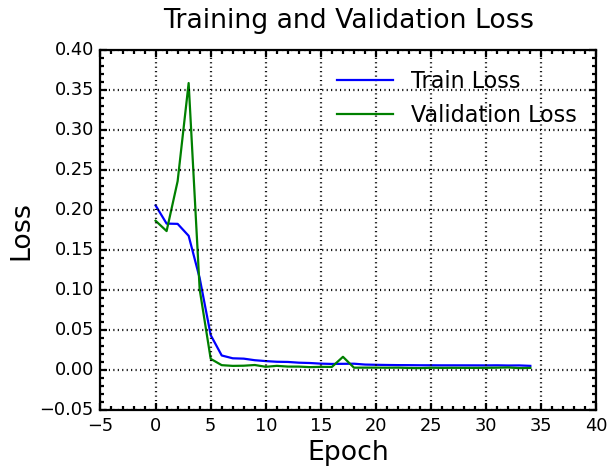

In [9]:
dgcnn_model, y_val_true, y_val_pred = train_dgcnn(
    data_list_train,
    data_list_val,
    activation=nn.PReLU(),
    loss=HuberRelativeLoss(delta=0.1),
    EdgeMLP_dims=[[16,16,16],[32,32,32]],
    mlp_dims=[128, 64, 32],
    dropout=0.1,
    lr=1e-3,
    weight_decay=5e-5,
    batch_size=batch_size,
    epochs=50,
    patience=10,
    val_split=0.2,
    random_state=random_state
)
torch.save(dgcnn_model, DataPath_Validate+f"/Models/DGCNN.pth")
# Evaluate on test set

In [10]:
def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
    #Step 1: Linear
    linear_range = (10,60)
    mask_lin = (x > linear_range[0]) & (x < linear_range[1])
    coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
    y_lin = np.poly1d(coeffs_lin)(x)
    residual = y - y_lin
    print("Step 1 Linear fit coeffs:", coeffs_lin)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
        plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Step 1: Linear Fit")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Step 2: exp fit
    #residual = y
    fit_range = (3, 20)
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    def fit_func2(x, a, b, c):
        return a * np.exp(b * x) + c
    coeff_fit2, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
    y_fit2 = fit_func2(x_fit2, *coeff_fit2)
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
        plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 2: exp Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    residual = y - fit_func2(x, *coeff_fit2)

    # Step 3: exp fit
    # if plot:
    #     plt.figure(figsize=(5,4))
    #     plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
    #     plt.xlabel("x")
    #     plt.ylabel("Residual")
    #     plt.title("Step 3: exp Fit Residual")
    #     plt.grid(True, linestyle="--", alpha=0.5)
    #     plt.show()
    # fit_range = (10, 30)
    # mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    # def fit_func3(x, a, b, c):
    #     return a * np.exp(b * x) + c
    # coeff_fit3, _ = curve_fit(fit_func3, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    # x_fit3 = np.linspace(fit_range[0], fit_range[1], 200)
    # y_fit3 = fit_func3(x_fit3, *coeff_fit3)
    # if plot:
    #     plt.plot(x_fit3, y_fit3, color="red", linestyle="-", label="Step3: exp Fit")

    # residual = y - fit_func2(x, *coeff_fit2) - fit_func3(x, *coeff_fit3)

    # Step 4: Linear again
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
    y_lin2 = np.poly1d(params_lin2)(x)
    print("Step 3 Linear fit coeffs:", params_lin2)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
        plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 3: Linear Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Final combined function
    def f(x_val):
        return ( 
                fit_func2(x_val, *coeff_fit2) + 
                #fit_func3(x_val, *coeff_fit3) + 
                np.poly1d(params_lin2)(x_val))
    return f
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = (y_truth == E_truth)
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            print(f"No events found for E_truth = {E_truth} GeV, skipping.")
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "E_truth": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist

Reco_hist_all = []

device = next(dgcnn_model.parameters()).device
dgcnn_model.eval()
test_loader = PyGDataLoader(data_list_test, batch_size=batch_size, shuffle=False)
y_test_true, y_test_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = dgcnn_model(batch)
        y_test_true.append(batch.y.cpu())
        y_test_pred.append(pred.cpu())
y_test_true = torch.cat(y_test_true, dim=0).numpy()
y_test_pred = torch.cat(y_test_pred, dim=0).numpy()

Reco_hist_all.clear()
Reco_hist = build_reco_hist(y_test_pred, E_truth_test, Energy_test, Nbins=50)
Reco_hist_all.append(Reco_hist)

# fit_range = (0, 65) 
# mask = y_val_pred>0
# residual_E = (y_val_pred[mask] - y_val_true[mask]) / y_val_pred[mask]
# E_calib_fit = Combined_fit(y_val_pred[mask], residual_E, fit_range=fit_range, plot=True, num_bins=200)
# x_fit = np.linspace(fit_range[0], fit_range[1], 200)
# y_fit = E_calib_fit(x_fit)
# plt.figure(figsize=fig_size)
# plot_binned(y_val_pred[mask], residual_E, num_bins=200, color="blue", label="Validate samples")
# #plot_binned(y_pred_test_mlp, (y_pred_test_mlp - y_test) / y_pred_test_mlp,num_bins=200, color="orange", label="Test samples")
# plt.plot(x_fit, y_fit, color='red', label='Fit')
# plt.xlabel("E_pred [GeV]")
# plt.ylabel("(E_pred - E_true)/E_pred")
# plt.title("Residual vs E_pred")
# plt.grid(True, linestyle="--", alpha=0.5)
# plt.legend(loc="lower right")
# plt.show()

# y_val_pred_calib = y_val_pred*(1-E_calib_fit(y_val_pred))
# y_test_pred_calib = y_test_pred*(1-E_calib_fit(y_test_pred))
# Reco_hist_all.clear()
# Reco_hist = build_reco_hist(y_test_pred_calib, E_truth_test, Energy_test, Nbins=50)
# Reco_hist_all.append(Reco_hist)

# plt.figure(figsize=fig_size)
# plot_binned(y_test_true, y_test_pred, color="blue", label="test samples")
# plot_binned(y_val_true, y_val_pred, color="green", label="validate samples")
# plt.xlabel("E_truth [GeV]")
# plt.ylabel("E_pred [GeV]")
# plt.title("MLP Reconstructed Energy vs True Energy")
# plt.grid(True, linestyle="--", alpha=0.5)
# plt.legend(loc="upper left")  
# plt.show()


In [11]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1-1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    print(f"Gamma Fit Bounds: lower {lower_bounds}, \n upper {upper_bounds}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Mean: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


length of Reco_hist_all: 1
length of Reco_hist: 12
Mean: 10.44832314836015, Peak: 10.28675651550293, RMS: 0.6619183347833398
Initial Gamma Fit Parameters: [np.float64(604.872407913208), np.float64(4.54247376072283), np.float32(7.4415765), np.float64(0.6619183347833398)]
Gamma Fit Bounds: lower [np.float64(6.04872407913208), np.float64(-0.5457526239277171), np.float32(-0.25584233), np.float64(0.06619183347833399)], 
 upper [np.float64(3629.234447479248), np.float64(45.424737607228295), np.float32(21.162365), np.float64(6.619183347833398)]
Gamma Fit Parameters: [5.99996655e+02 4.54247376e+01 6.16066455e+00 9.52375085e-02]
Gamma Fit Peak: 10.391565877470104 ± 0.014031669296961513, Mean: 10.48680338598804 ± 0.014157982766886222, Resolution: 0.06176938024301205 ± 0.0009403375668012783


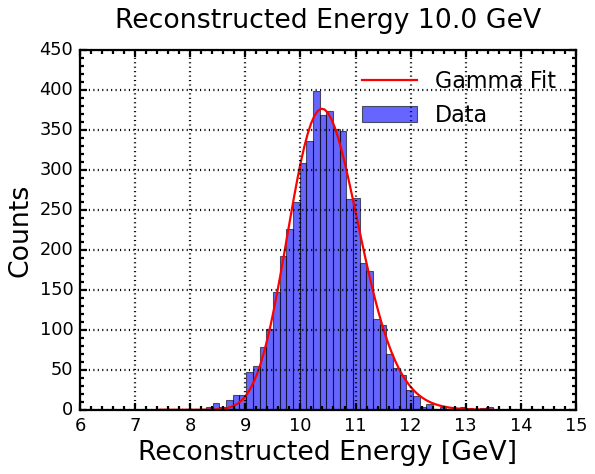

In [12]:
#This cell is left here for debug
print("length of Reco_hist_all:", len(Reco_hist_all))
Reco_hist = Reco_hist_all[0] # Example for first beta
print("length of Reco_hist:", len(Reco_hist))
i_E = 6 # Example index, change as needed
#print(len(Reco_hist))
#print(Reco_hist[i_E])
mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all(
    "E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])

Mean: 0.11577925388350822, Peak: 0.10754500329494476, RMS: 0.06281278027208201
Initial Gamma Fit Parameters: [np.float64(130.56119088828564), np.float64(2.0081932701999654), np.float32(-0.010360949), np.float64(0.06281278027208201)]
Gamma Fit Bounds: lower [np.float64(1.3056119088828564), np.float64(-0.7991806729800035), np.float32(-1.001036), np.float64(0.006281278027208201)], 
 upper [np.float64(783.3671453297138), np.float64(20.081932701999655), np.float32(9.984459), np.float64(0.6281278027208201)]
Gamma Fit Parameters: [ 1.27747173e+02  2.00819327e+01 -7.70731642e-02  9.33928731e-03]
Gamma Fit Peak: 0.10113848774878134 ± 0.0005719743942921929, Mean: 0.11047777505848458 ± 0.0005839972632851172, Resolution: 0.4138090972833873 ± 0.005359916972312711


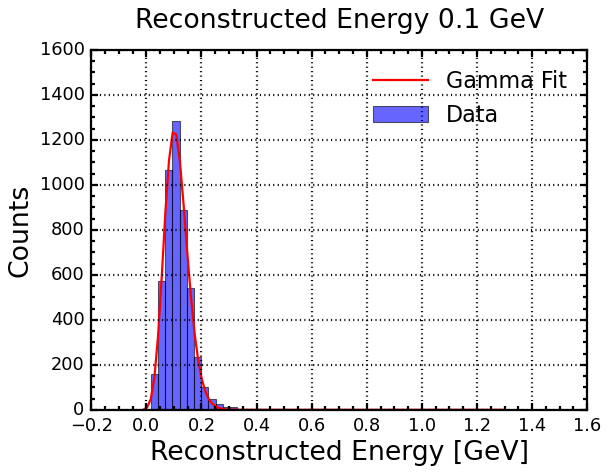

appending results for E = 0.1
Mean_Gamma: 0.11047777505848458 Mean_Gamma_Error: 0.0005839972632851172
Peak_Gamma: 0.10113848774878134 Peak_Gamma_Error: 0.0005719743942921929
Mean: 0.25783445804443883, Peak: 0.21618777513504028, RMS: 0.08428070028277383
Initial Gamma Fit Parameters: [np.float64(66.71525961533189), np.float64(2.7938760998636725), np.float32(0.022364624), np.float64(0.08428070028277383)]
Gamma Fit Bounds: lower [np.float64(0.6671525961533189), np.float64(-0.7206123900136328), np.float32(-0.9977635), np.float64(0.008428070028277383)], 
 upper [np.float64(400.29155769199133), np.float64(27.938760998636724), np.float32(10.033547), np.float64(0.8428070028277383)]
Gamma Fit Parameters: [6.68751760e+01 4.90415695e+00 6.90289056e-02 3.89568995e-02]
Gamma Fit Peak: 0.22112275539248671 ± 0.0013081295236379996, Mean: 0.2600796548603058 ± 0.0014389664870757552, Resolution: 0.3901513620995284 ± 0.007278671107760473


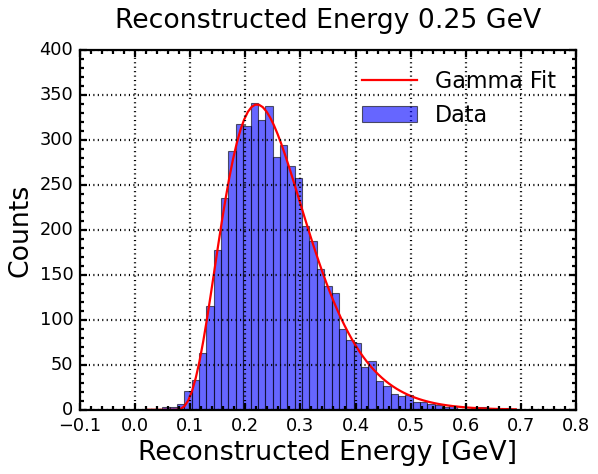

appending results for E = 0.25
Mean_Gamma: 0.2600796548603058 Mean_Gamma_Error: 0.0014389664870757552
Peak_Gamma: 0.22112275539248671 Peak_Gamma_Error: 0.0013081295236379996
Mean: 0.5243111306751097, Peak: 0.4971883296966553, RMS: 0.12450668358731891
Initial Gamma Fit Parameters: [np.float64(121.93047171458602), np.float64(4.040968750222482), np.float32(0.021183513), np.float64(0.12450668358731891)]
Gamma Fit Bounds: lower [np.float64(1.2193047171458602), np.float64(-0.5959031249777518), np.float32(-0.99788165), np.float64(0.012450668358731891)], 
 upper [np.float64(731.5828302875161), np.float64(40.40968750222482), np.float32(10.031775), np.float64(1.2450668358731891)]
Gamma Fit Parameters: [ 1.20890360e+02  3.71670081e+01 -2.08715864e-01  1.97028688e-02]
Gamma Fit Peak: 0.5038779520284445 ± 0.0015809027815129912, Mean: 0.5235808208467586 ± 0.0015984465522044997, Resolution: 0.2383871883938732 ± 0.0024538644746614326


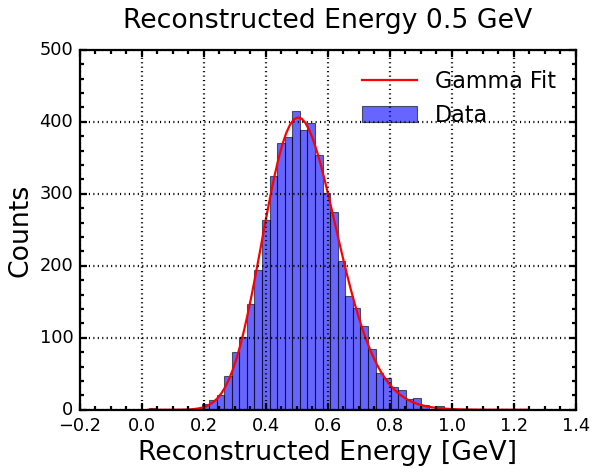

appending results for E = 0.5
Mean_Gamma: 0.5235808208467586 Mean_Gamma_Error: 0.0015984465522044997
Peak_Gamma: 0.5038779520284445 Peak_Gamma_Error: 0.0015809027815129912
Mean: 1.0522646418182826, Peak: 1.0188394784927368, RMS: 0.18210046157042792
Initial Gamma Fit Parameters: [np.float64(158.43015217781067), np.float64(4.275900421053804), np.float32(0.2736212), np.float64(0.18210046157042792)]
Gamma Fit Bounds: lower [np.float64(1.5843015217781067), np.float64(-0.5724099578946196), np.float32(-0.9726379), np.float64(0.018210046157042793)], 
 upper [np.float64(950.580913066864), np.float64(42.759004210538045), np.float32(10.410432), np.float64(1.8210046157042792)]
Gamma Fit Parameters: [1.56961938e+02 3.33285032e+01 4.40674816e-02 3.02544940e-02]
Gamma Fit Peak: 1.022149986814716 ± 0.003313385457835818, Mean: 1.0524044807841413 ± 0.0033544082663800176, Resolution: 0.17087682695061618 ± 0.002456066420181541


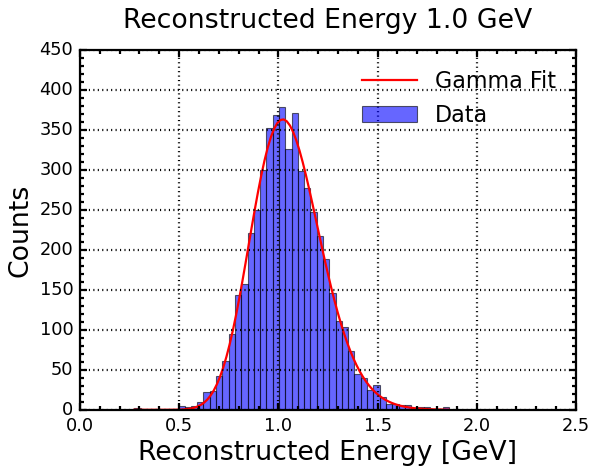

appending results for E = 1.0
Mean_Gamma: 1.0524044807841413 Mean_Gamma_Error: 0.0033544082663800176
Peak_Gamma: 1.022149986814716 Peak_Gamma_Error: 0.003313385457835818
Mean: 2.1249125312460295, Peak: 2.0792336463928223, RMS: 0.28480486240225844
Initial Gamma Fit Parameters: [np.float64(231.40999698638916), np.float64(3.1703304310945204), np.float32(1.221987), np.float64(0.28480486240225844)]
Gamma Fit Bounds: lower [np.float64(2.3140999698638915), np.float64(-0.6829669568905479), np.float32(-0.8778013), np.float64(0.028480486240225845)], 
 upper [np.float64(1388.459981918335), np.float64(31.703304310945203), np.float32(11.83298), np.float64(2.848048624022584)]
Gamma Fit Parameters: [2.29815891e+02 3.17033043e+01 5.66672732e-01 4.91878151e-02]
Gamma Fit Peak: 2.0769011875204884 ± 0.005811479097985182, Mean: 2.12608900261092 ± 0.005887100269675616, Resolution: 0.1333502891674633 ± 0.002085119734856452


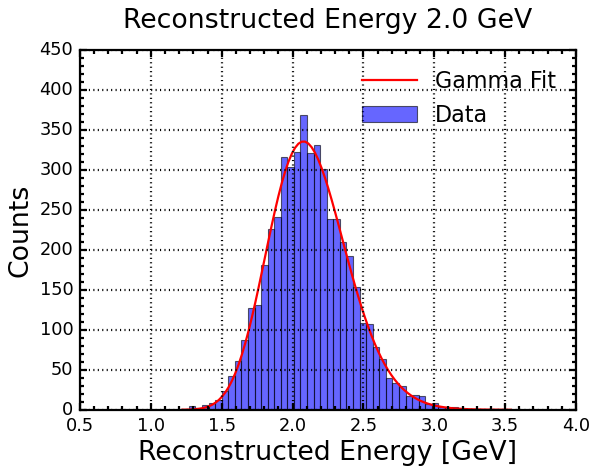

appending results for E = 2.0
Mean_Gamma: 2.12608900261092 Mean_Gamma_Error: 0.005887100269675616
Peak_Gamma: 2.0769011875204884 Peak_Gamma_Error: 0.005811479097985182
Mean: 5.366826860628751, Peak: 5.3292317390441895, RMS: 0.4551409310278257
Initial Gamma Fit Parameters: [np.float64(392.1458468437195), np.float64(3.791903897028813), np.float32(3.6409762), np.float64(0.4551409310278257)]
Gamma Fit Bounds: lower [np.float64(3.9214584684371947), np.float64(-0.6208096102971187), np.float32(-0.6359024), np.float64(0.04551409310278257)], 
 upper [np.float64(2352.875081062317), np.float64(37.91903897028813), np.float32(15.461464), np.float64(4.551409310278257)]
Gamma Fit Parameters: [3.93591066e+02 3.79190390e+01 2.56181628e+00 7.43805436e-02]
Gamma Fit Peak: 5.307874466230335 ± 0.0075745976462556165, Mean: 5.382255009858834 ± 0.007656656329409378, Resolution: 0.08629137039310146 ± 0.0010199145042249717


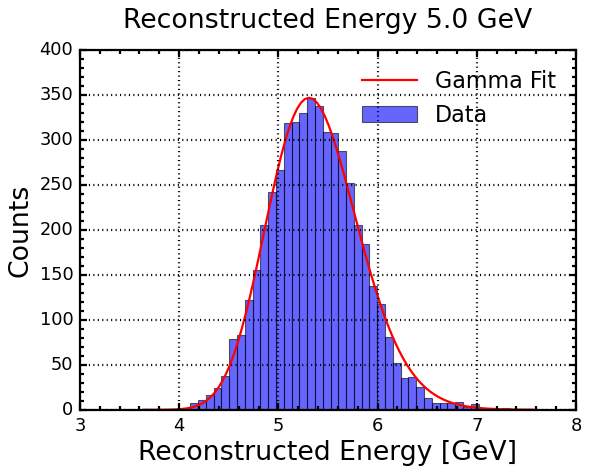

appending results for E = 5.0
Mean_Gamma: 5.382255009858834 Mean_Gamma_Error: 0.007656656329409378
Peak_Gamma: 5.307874466230335 Peak_Gamma_Error: 0.0075745976462556165
Mean: 10.44832314836015, Peak: 10.28675651550293, RMS: 0.6619183347833398
Initial Gamma Fit Parameters: [np.float64(604.872407913208), np.float64(4.54247376072283), np.float32(7.4415765), np.float64(0.6619183347833398)]
Gamma Fit Bounds: lower [np.float64(6.04872407913208), np.float64(-0.5457526239277171), np.float32(-0.25584233), np.float64(0.06619183347833399)], 
 upper [np.float64(3629.234447479248), np.float64(45.424737607228295), np.float32(21.162365), np.float64(6.619183347833398)]
Gamma Fit Parameters: [5.99996655e+02 4.54247376e+01 6.16066455e+00 9.52375085e-02]
Gamma Fit Peak: 10.391565877470104 ± 0.014031669296961513, Mean: 10.48680338598804 ± 0.014157982766886222, Resolution: 0.06176938024301205 ± 0.0009403375668012783


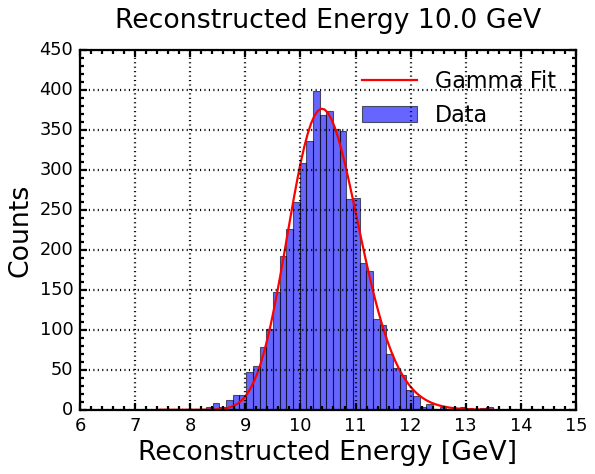

appending results for E = 10.0
Mean_Gamma: 10.48680338598804 Mean_Gamma_Error: 0.014157982766886222
Peak_Gamma: 10.391565877470104 Peak_Gamma_Error: 0.014031669296961513
Mean: 20.368788729489303, Peak: 20.400516510009766, RMS: 0.9076906589151482
Initial Gamma Fit Parameters: [np.float64(813.23193359375), np.float64(4.719194089421243), np.float32(16.08522), np.float64(0.9076906589151482)]
Gamma Fit Bounds: lower [np.float64(8.1323193359375), np.float64(-0.5280805910578756), np.float32(0.60852206), np.float64(0.09076906589151483)], 
 upper [np.float64(4879.3916015625), np.float64(47.19194089421243), np.float32(34.12783), np.float64(9.076906589151482)]
Gamma Fit Parameters: [8.10934758e+02 4.71919409e+01 1.42289407e+01 1.31515264e-01]
Gamma Fit Peak: 20.303886025982646 ± 0.024373782843175953, Mean: 20.43540129027672 ± 0.024585743883248114, Resolution: 0.04449701875658847 ± 0.000827708907293001


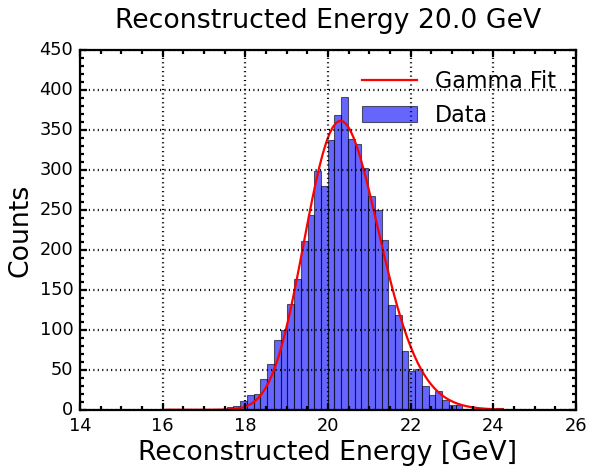

appending results for E = 20.0
Mean_Gamma: 20.43540129027672 Mean_Gamma_Error: 0.024585743883248114
Peak_Gamma: 20.303886025982646 Peak_Gamma_Error: 0.024373782843175953
Mean: 30.036726282843123, Peak: 30.181156158447266, RMS: 1.150841407426013
Initial Gamma Fit Parameters: [np.float64(1054.4791831970215), np.float64(4.5530975951175225), np.float32(24.796833), np.float64(1.150841407426013)]
Gamma Fit Bounds: lower [np.float64(10.544791831970215), np.float64(-0.5446902404882477), np.float32(1.4796834), np.float64(0.1150841407426013)], 
 upper [np.float64(6326.875099182129), np.float64(45.53097595117522), np.float32(47.19525), np.float64(11.508414074260129)]
Gamma Fit Parameters: [1.05415924e+03 4.55309760e+01 2.24441959e+01 1.68147616e-01]
Gamma Fit Peak: 29.93197330600623 ± 0.03104850105568617, Mean: 30.100120922034186 ± 0.031327072191533384, Resolution: 0.0379060773799869 ± 0.0007151819718864912


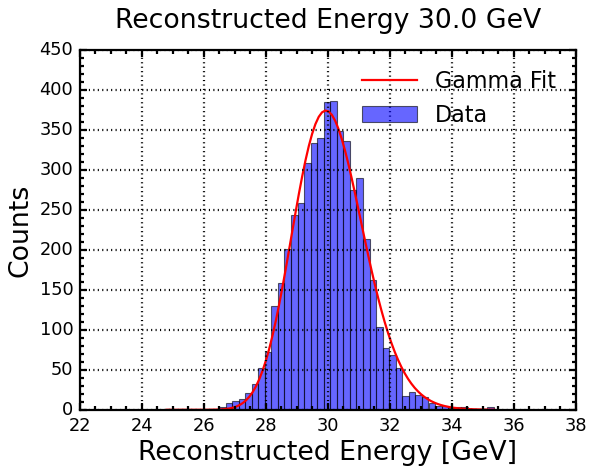

appending results for E = 30.0
Mean_Gamma: 30.100120922034186 Mean_Gamma_Error: 0.031327072191533384
Peak_Gamma: 29.93197330600623 Peak_Gamma_Error: 0.03104850105568617
Mean: 39.98436061794216, Peak: 39.79543685913086, RMS: 1.337621964865583
Initial Gamma Fit Parameters: [np.float64(1172.2655868530273), np.float64(3.9134176625486035), np.float32(34.749687), np.float64(1.337621964865583)]
Gamma Fit Bounds: lower [np.float64(11.722655868530273), np.float64(-0.6086582337451396), np.float32(2.4749687), np.float64(0.1337621964865583)], 
 upper [np.float64(7033.593521118164), np.float64(39.134176625486035), np.float32(62.12453), np.float64(13.37621964865583)]
Gamma Fit Parameters: [1.16294546e+03 3.91341766e+01 3.19228205e+01 2.07195007e-01]
Gamma Fit Peak: 39.824031516904 ± 0.02581675792153256, Mean: 40.031226524357905 ± 0.02608702275854529, Resolution: 0.03254708993026989 ± 0.00045122478797375766


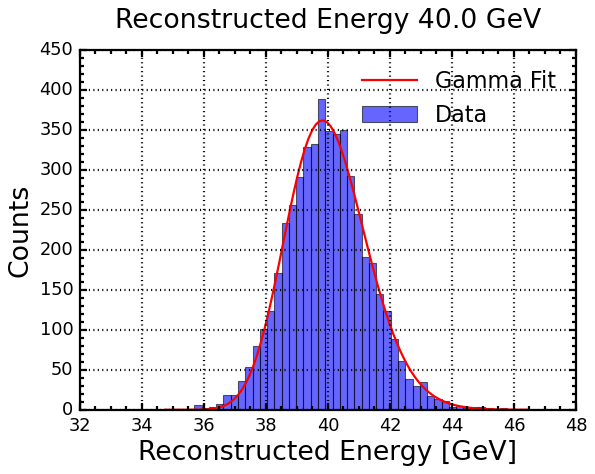

appending results for E = 40.0
Mean_Gamma: 40.031226524357905 Mean_Gamma_Error: 0.02608702275854529
Peak_Gamma: 39.824031516904 Peak_Gamma_Error: 0.02581675792153256
Mean: 49.99473891818158, Peak: 50.06928253173828, RMS: 1.4329623571649852
Initial Gamma Fit Parameters: [np.float64(1050.681697845459), np.float64(3.5415239092418127), np.float32(44.91987), np.float64(1.4329623571649852)]
Gamma Fit Bounds: lower [np.float64(10.50681697845459), np.float64(-0.6458476090758187), np.float32(3.4919868), np.float64(0.14329623571649852)], 
 upper [np.float64(6304.090187072754), np.float64(35.415239092418126), np.float32(77.37981), np.float64(14.329623571649853)]
Gamma Fit Parameters: [1.04368917e+03 3.54152391e+01 4.16310341e+01 2.38595001e-01]
Gamma Fit Peak: 49.84233808646876 ± 0.03828177679579709, Mean: 50.080933087541204 ± 0.038737824141294834, Resolution: 0.02848774168152545 ± 0.0005383331816334547


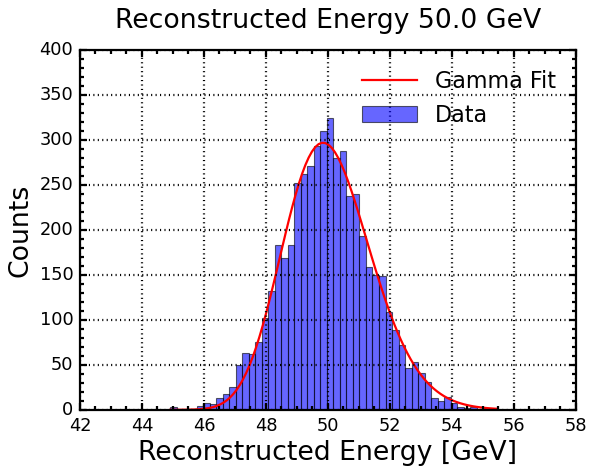

appending results for E = 50.0
Mean_Gamma: 50.080933087541204 Mean_Gamma_Error: 0.038737824141294834
Peak_Gamma: 49.84233808646876 Peak_Gamma_Error: 0.03828177679579709
Mean: 59.58831642053105, Peak: 60.07635498046875, RMS: 1.5394329691242434
Initial Gamma Fit Parameters: [np.float64(1242.0037460327148), np.float64(4.448796322998612), np.float32(52.739693), np.float64(1.5394329691242434)]
Gamma Fit Bounds: lower [np.float64(12.42003746032715), np.float64(-0.5551203677001388), np.float32(4.273969), np.float64(0.15394329691242437)], 
 upper [np.float64(7452.022476196289), np.float64(44.487963229986114), np.float32(89.10954), np.float64(15.394329691242435)]
Gamma Fit Parameters: [1.23901635e+03 4.44879632e+01 4.94352716e+01 2.30546879e-01]
Gamma Fit Peak: 59.46128578175407 ± 0.04555177268761517, Mean: 59.691832660767965 ± 0.04599777913605773, Resolution: 0.025861053507876427 ± 0.0005267616986415589


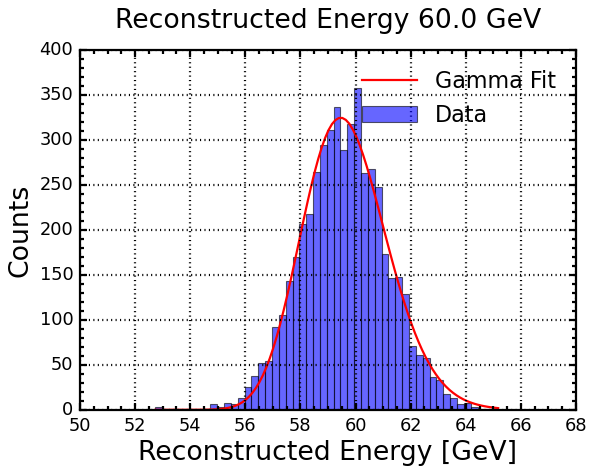

appending results for E = 60.0
Mean_Gamma: 59.691832660767965 Mean_Gamma_Error: 0.04599777913605773
Peak_Gamma: 59.46128578175407 Peak_Gamma_Error: 0.04555177268761517


In [13]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
def OutputCSV(Reco_hist, Energy_test, CSV_name):
    results = []
    for i_E in range(len(Energy_test)):
        mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
        mean_log_normal,mean_log_normal_error,peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
        mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])
        print("appending results for E =", Energy_test[i_E])
        print("Mean_Gamma:", mean_gamma, "Mean_Gamma_Error:", mean_gamma_error)
        print("Peak_Gamma:", peak_gamma, "Peak_Gamma_Error:", peak_gamma_error)
        results.append({
            "ParticleEnergy": Energy_test[i_E],
            "Mean_Gauss": mean_gauss,
            "Mean_Gauss_Error": mean_gauss_error,
            "Peak_Gauss": peak_gauss,
            "Peak_Gauss_Error": peak_gauss_error,
            "Res_Gauss": res_gauss,
            "Res_Gauss_Error": res_gauss_error,
            "Mean_Gamma": mean_gamma,
            "Mean_Gamma_Error": mean_gamma_error,
            "Peak_Gamma": peak_gamma,
            "Peak_Gamma_Error": peak_gamma_error,
            "Res_Gamma": res_gamma,
            "Res_Gamma_Error": res_gamma_error,
            "Mean_LogNormal": mean_log_normal,
            "Mean_LogNormal_Error": mean_log_normal_error,
            "Peak_LogNormal": peak_log_normal,
            "Peak_LogNormal_Error": peak_log_normal_error,
            "Res_LogNormal": res_log_normal,
            "Res_LogNormal_Error": res_log_normal_error
        })
    df = pd.DataFrame(results)
    df.to_csv(CSV_name, index=False)
outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_DGCNN2_Fit.csv")
OutputCSV(Reco_hist_all[0], Energy_test, outputfile_name)
# for i_para, para in enumerate(ParameterScan):
#     if i_para != 0:
#         continue  # 
#     #outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_LR{para:.0e}_Fit.csv")
#     outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Fit.csv")
#     OutputCSV(Reco_hist_mlp_all[i_para], Energy_test, outputfile_name)
#     print(f"Saved fit results to {outputfile_name}")